In [ ]:
import pandas as pd
import json
import os
from plots import *

print(os.getcwd())
print(os.chdir('/Users/soren/Work/autolr'))
#print(os.chdir('C:\\Users\\lamec\\WORK\\autolr'))
print(os.getcwd())

parameter_file = 'parameters/imagenet.yml'
from sge.parameters import load_parameters, params
phen_params = (None, params)
load_parameters(parameter_file)
from utils.smart_phenotype import readable_phenotype, smart_phenotype
from utils.visualization_tools import *


In [ ]:
run_number = range(1, 33)
#task = "tensorflow"
folder = "C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results"
folder = "C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results\\STEFANO EXPERIMENTS FM"
folder = '/Users/soren/Work/autolr/results/arch_optimizer'
# Create the DataFrame with ified columns and data types
df = pd.DataFrame({
    'experiment_name': pd.Series(dtype='string'),
    'run_number': pd.Series(dtype='string'),
    'genetic_id': pd.Series(dtype='int64'),
    'phenotype': pd.Series(dtype='string'),
    'smart_phenotype': pd.Series(dtype='string'),
    'fitness': pd.Series(dtype='float64'),
	'duration': pd.Series(dtype='float64'),
	'source': pd.Series(dtype='string'),
    'operation': pd.Series(dtype='string'),
})


df = load_results(folder)

#archive = json.load(open('C:\\Users\\lamec\\WORK\\autolr\\results\\arch_optimizers_results\\resnet\\run_8\\z-archive_144.json'))\
df['fitness'] = df['fitness'] * -1
archive = {}
for ix, row in df.iterrows():
    if row['smart_phenotype'] not in archive:
        archive[row['smart_phenotype']] = {'id': len(archive), 'phenotype': row['phenotype'], 'fitness': row['fitness']}

In [ ]:
def get_parents_id_new_archive(x):
    if x is None:
        print("uh oh")
    print(x['parents'])
    if x['parents'] is None or None in x['parents']:
        return x
    updated_parents = []
    try:
        p1_new_id = archive[df[df['genetic_id'] == int(x['parents'][0])]['smart_phenotype'].item()]['id']
        updated_parents.append(p1_new_id)
    except:
        updated_parents.append(None)
    try:
        p2_new_id = archive[df[df['genetic_id'] == int(x['parents'][1])]['smart_phenotype'].item()]['id']
        updated_parents.append(p2_new_id)
    except:
        updated_parents.append(None)
    x['parents'] = updated_parents
    return x['parents']
#df['parents'] = df.apply(get_parents_id_new_archive, axis=1)
individual_counts = df.groupby(['experiment_name', 'run_number'])['genetic_id'].nunique().reset_index(name='Unique Individual Count')
df['generation'] = df['generation'].astype(int)
if 'source' in df.columns:
    df['source'] = df['source'].apply(lambda x: 'archive' if x == 'elitism' else x)
df['behavior_id'] = df['smart_phenotype'].apply(lambda x: archive[x]['id'])
if 'source' in df.columns and 'operation' in df.columns:
    df['source+operation'] = df.apply(lambda row: str(row['source']) + ' + ' + str(row['operation']), axis=1)
best_fitness_generations = []
highest_fitness = float('-inf')

for _, row in df.sort_values('generation').iterrows():
    if row['fitness'] > highest_fitness:
        highest_fitness = row['fitness']
        best_fitness_generations.append(row['generation'])
        print(f"behavior_id: {row['behavior_id']}, generation: {row['generation']}, fitness: {row['fitness']}")
df.head(5)

In [ ]:
df_crossover = df[df['operation'] == 'crossover']
df_crossover['parents']

In [ ]:
df_crossover = df[df['operation'] == 'crossover']
df_crossover['parent_1'] = df_crossover['parents'].apply(lambda x: int(x[0]))
df_crossover['parent_2'] = df_crossover['parents'].apply(lambda x: int(x[1]))
for ix, row in df_crossover.iterrows():
    #print(df[df['genetic_id'] == row['parent_2']]['phenotype'])
    p1_phenotype = df[df['genetic_id'] == row['parent_1']]['phenotype'].head(1).item()
    p2_phenotype = df[df['genetic_id'] == row['parent_2']]['phenotype'].head(1).item()

    print(f"Child: {row['genetic_id']} Readable Phenotype: {readable_phenotype(row['phenotype'])}")
    print(f"P1: {row['parent_1']} Readable Phenotype: {readable_phenotype(p1_phenotype)}")
    print(f"P2: {row['parent_2']} Readable Phenotype: {readable_phenotype(p2_phenotype)}")
    print("--------\n\n")

    


In [30]:
#df.to_csv('all_results.csv', index=False)
#df_crossover.to_csv('crossover_results.csv', index=False)
#df_mutation.to_csv('mutation_results.csv', index=False)
df_crossover = get_crossover_df(df)
df_mutation = get_mutation_df(df)

/Users/soren/Work/autolr/utils/plots.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_1'] = df_crossover['parents'].apply(lambda x: int(x[0]))
/Users/soren/Work/autolr/utils/plots.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_2'] = df_crossover['parents'].apply(lambda x: int(x[1]))
/Users/soren/Work/autolr/utils/plots.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

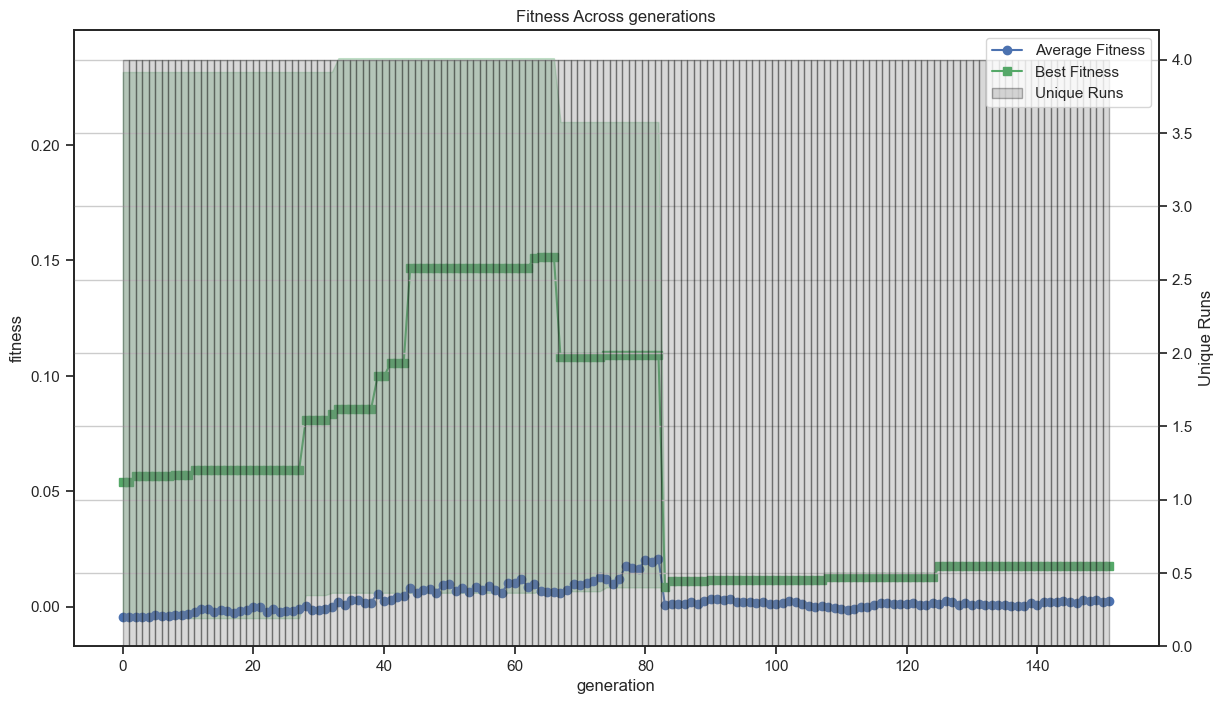

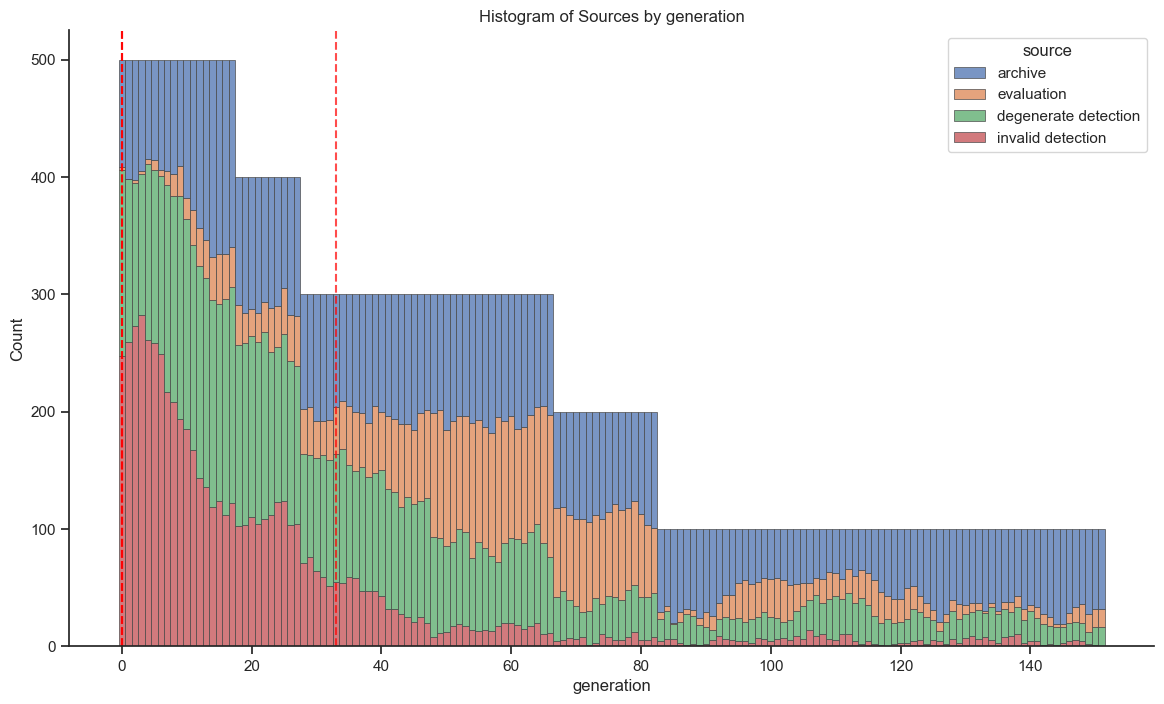

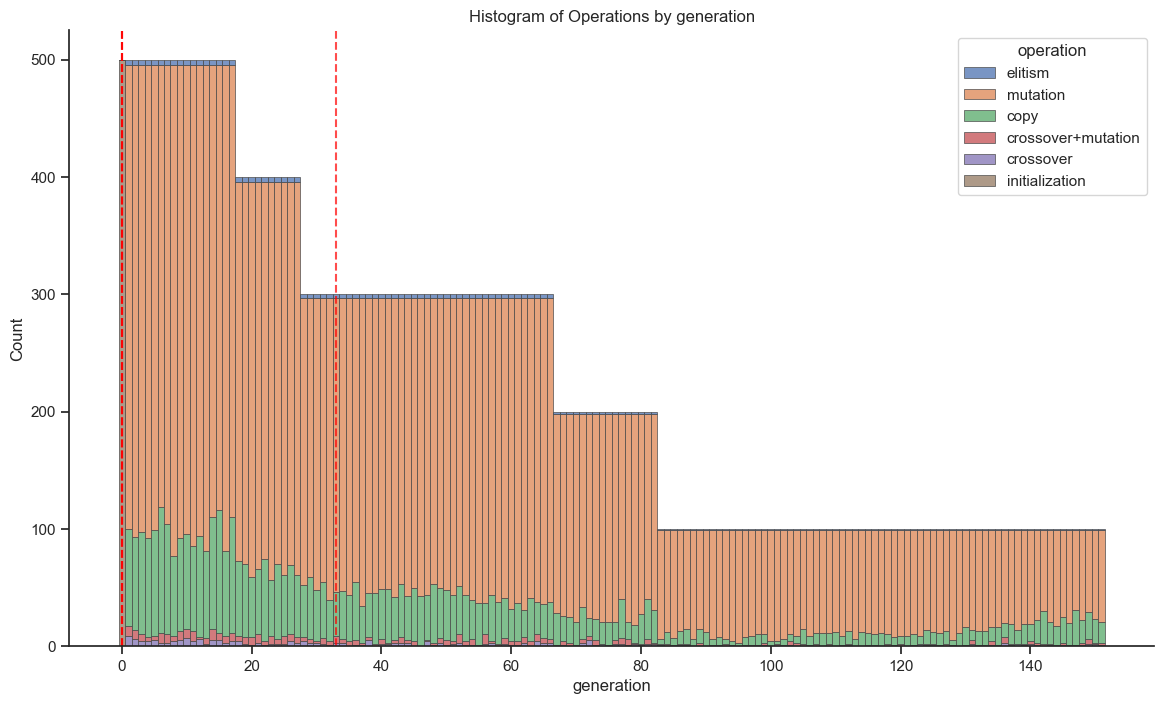


Combined count and percentage display:
source                   archive degenerate detection    evaluation  \
operation                                                             
copy                2276 (48.8%)          723 (15.5%)   692 (14.8%)   
crossover            168 (68.9%)           30 (12.3%)     14 (5.7%)   
crossover+mutation   233 (55.6%)          105 (25.1%)     35 (8.4%)   
elitism             343 (100.0%)             0 (0.0%)      0 (0.0%)   
initialization        92 (18.4%)          159 (31.8%)      2 (0.4%)   
mutation            9670 (33.8%)         8821 (30.8%)  5163 (18.0%)   

source             invalid detection  
operation                             
copy                     977 (20.9%)  
crossover                 32 (13.1%)  
crossover+mutation        46 (11.0%)  
elitism                     0 (0.0%)  
initialization           247 (49.4%)  
mutation                4972 (17.4%)  
   experiment_name run_number  genetic_id generation  \
0  experiment_name     

/Users/soren/Work/autolr/utils/plots.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_1'] = df_crossover['parents'].apply(lambda x: int(x[0]))
/Users/soren/Work/autolr/utils/plots.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crossover['parent_2'] = df_crossover['parents'].apply(lambda x: int(x[1]))
/Users/soren/Work/autolr/utils/plots.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

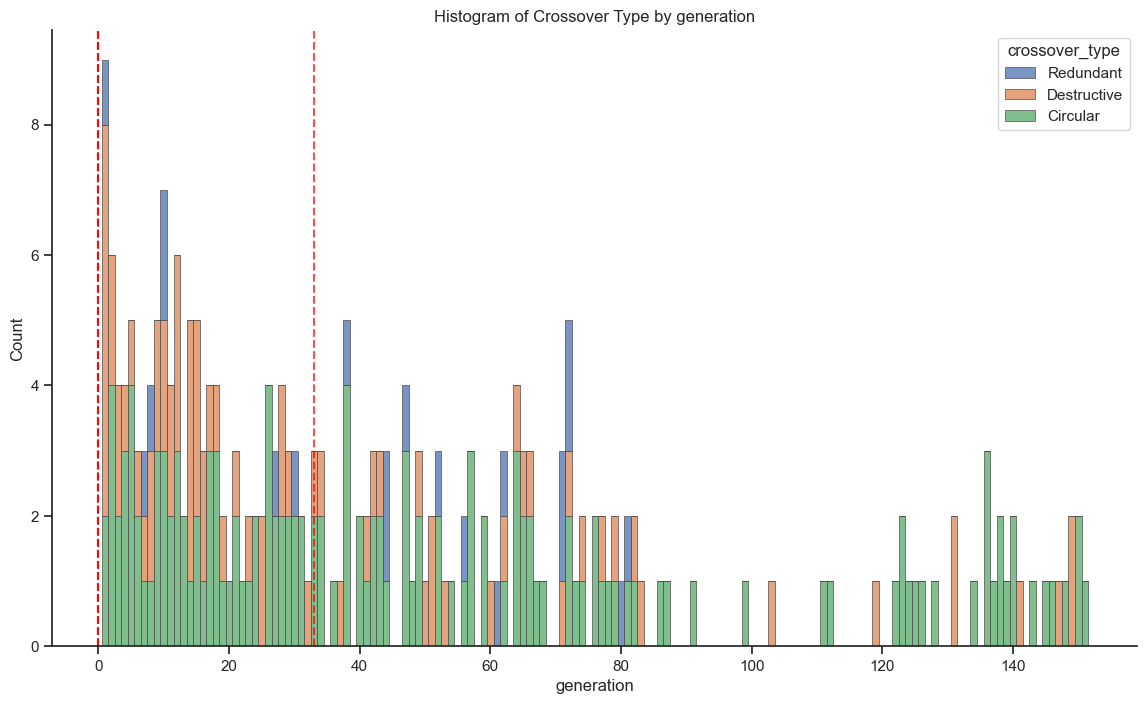

/Users/soren/Work/autolr/utils/plots.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mutation['parent_1'] = df_mutation['parents'].apply(lambda x: int(x[0]))
/Users/soren/Work/autolr/utils/plots.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mutation['mutation_type'] = df_mutation.apply(determine_mutation_type, axis=1)
/Users/soren/Work/autolr/utils/plots.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

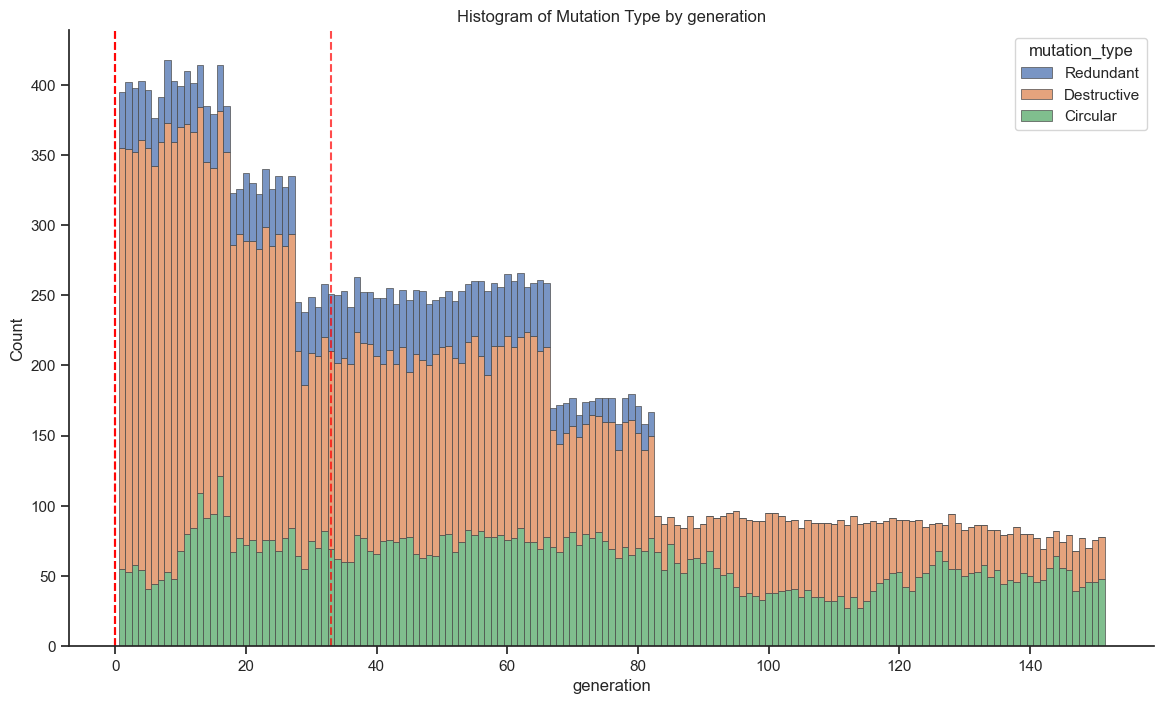

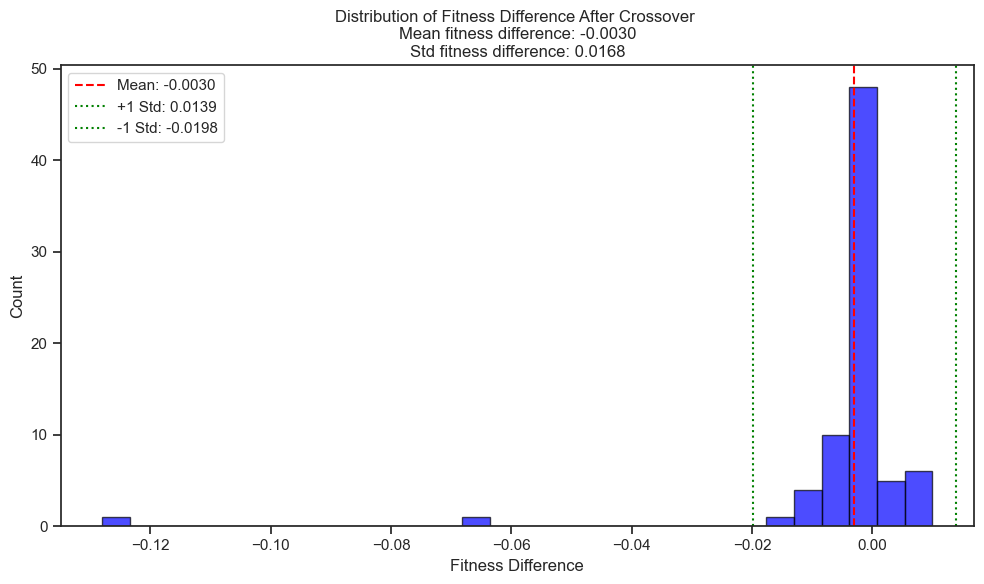

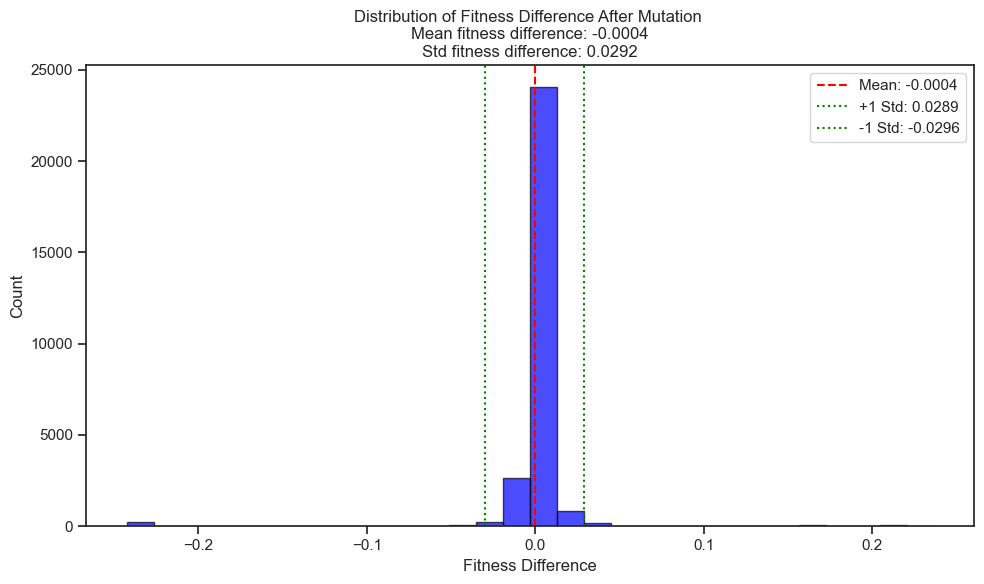

In [33]:
#df = df[df['experiment_name'] == 'SMX']
plot_fitness_and_unique_runs(df)
plot_sources_per_generation(df, best_fitness_generations)
plot_operations_per_generation(df, best_fitness_generations)
print_sources_per_operation(df)
#plot_grouped_stacked_histogram(df, 10, 10, 15)
#plot_percentile_grouped_stacked_histogram(df)
#plot_operation_and_sources_per_generation(df)
plot_crossover_type(df, best_fitness_generations)
plot_mutation_type(df, best_fitness_generations)
plot_fitness_difference_after_crossover(df, df_crossover)
plot_fitness_difference_after_mutation(df, df_mutation)


In [ ]:
#df_mutation = get_mutation_df(df)
df_crossover = get_crossover_df(df)

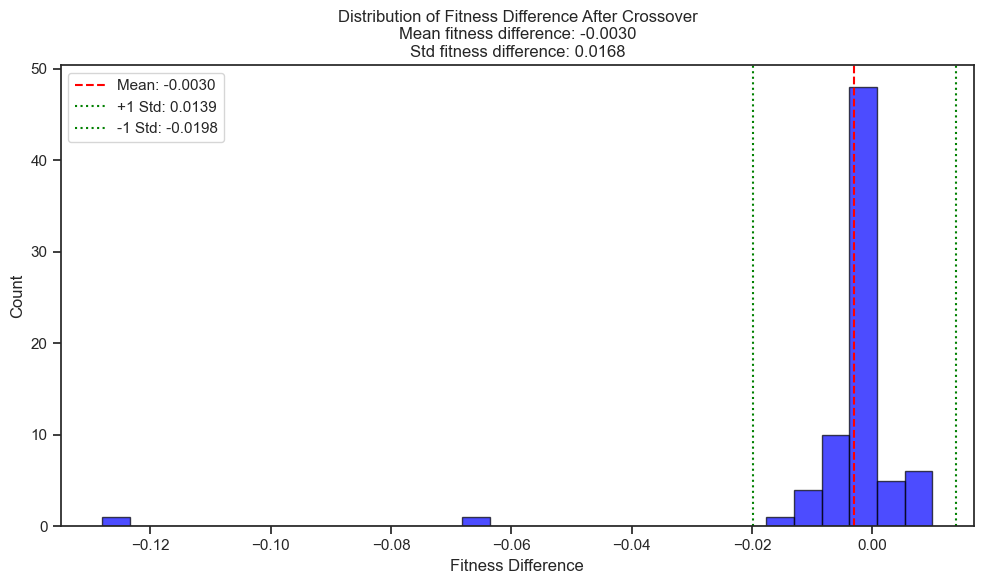

In [32]:
import numpy as np
import matplotlib.pyplot as plt

df_crossover = df_crossover[df_crossover['crossover_type'] == 'Destructive']
# Calculate parent fitness averages and difference for each crossover
def get_crossover_fitness_diff(df, df_crossover):
    parent_avg_fitness = []
    fitness_diff = []

    for _, row in df_crossover.iterrows():
        # Get parent fitness values
        p1_fit = df[df['genetic_id'] == row['parent_1']]['fitness']
        p2_fit = df[df['genetic_id'] == row['parent_2']]['fitness']
        # Use .head(1) to avoid duplicates, .item() to get value
        p1_fit = p1_fit.head(1).item() if not p1_fit.empty else np.nan
        p2_fit = p2_fit.head(1).item() if not p2_fit.empty else np.nan
        avg_fit = np.nanmean([p1_fit, p2_fit])
        parent_avg_fitness.append(avg_fit)
        fitness_diff.append(row['fitness'] - avg_fit)

    df_crossover = df_crossover.copy()
    df_crossover['parent_avg_fitness'] = parent_avg_fitness
    df_crossover['fitness_diff'] = fitness_diff
    return df_crossover

df_crossover = get_crossover_fitness_diff(df, df_crossover)
# Visualization
mean_diff = np.nanmean(df_crossover['fitness_diff'])
std_diff = np.nanstd(df_crossover['fitness_diff'])

plt.figure(figsize=(10, 6))
plt.hist(df_crossover['fitness_diff'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.4f}')
plt.axvline(mean_diff + std_diff, color='green', linestyle=':', label=f'+1 Std: {mean_diff + std_diff:.4f}')
plt.axvline(mean_diff - std_diff, color='green', linestyle=':', label=f'-1 Std: {mean_diff - std_diff:.4f}')
plt.title(f'Distribution of Fitness Difference After Crossover\nMean fitness difference: {mean_diff:.4f}\nStd fitness difference: {std_diff:.4f}')
plt.xlabel('Fitness Difference')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df

In [ ]:
df_mutation = get_mutation_df(df)
df_mutation = df_mutation[df_mutation['mutation_type'] == "Destructive"]
print(f"Found {len(df_mutation)} Destructive mutations")
count = 0
for ix, row in df_mutation.iterrows():
    p1_smart_phenotype = df[df['genetic_id'] == row['parent_1']]['smart_phenotype'].head(1).item()
    #p2_smart_phenotype = df[df['genetic_id'] == row['parent_2']]['smart_phenotype'].head(1).item()
    p1_phenotype = df[df['genetic_id'] == row['parent_1']]['phenotype'].head(1).item()
    #p2_phenotype = df[df['genetic_id'] == row['parent_2']]['phenotype'].head(1).item()
    c_archive_id = archive[row['smart_phenotype']]['id']
    p1_archive_id = archive[p1_smart_phenotype]['id']
    #p2_archive_id = archive[p2_smart_phenotype]['id']
    p1_fit = archive[p1_smart_phenotype]['fitness']
    #p2_fit = archive[p2_smart_phenotype]['fitness']
    p1_genotype = df[df['genetic_id'] == row['parent_1']]['genotype'].head(1).item()
    #p2_genotype = df[df['genetic_id'] == row['parent_2']]['genotype'].head(1).item()



    print(f"[GEN: {row['generation']} BID:{c_archive_id} FIT:{row['fitness']}]Child: {row['genetic_id']} Phenotype:\n {readable_phenotype(row['phenotype'])}")
    #print(f"[BID:{p1_archive_id} FIT:{p1_fit}]P1: {row['parent_1']} Phenotype:\n {readable_phenotype(p1_phenotype)}")
    #print(f"[BID:{p2_archive_id} FIT:{p2_fit}]P2: {row['parent_2']} Phenotype:\n {readable_phenotype(p2_phenotype)}")

    #for c_g, p1_g in zip(row['genotype'], p1_genotype):
    #    print(f"{c_g} {p1_g}")
    #print("--------\n\n")

In [29]:
printed_bid = []
for ix, row in df.sort_values('fitness', ascending=False).iterrows():
    if row['behavior_id'] in printed_bid:
        continue
    if row['fitness'] < 0.051:
        continue
    printed_bid.append(row['behavior_id'])
    print(f"behavior_id: {row['behavior_id']}, {row['run_number']}, generation: {row['generation']}, fitness: {row['fitness']}")
    print(f"Phenotype: \n{readable_phenotype(row['phenotype'])}")
    print("--------\n\n")


behavior_id: 151, run_2, generation: 64, fitness: 0.23766666650772095
Phenotype: 
alpha = alpha - multiply(subtract(constant(4.74768924e-01), grad), subtract(add(square(constant(9.98850958e-01)), square(multiply(multiply(has_units, units), layer_num))), multiply(has_pool_size, pool_size)))
beta = beta - negative(add(subtract(grad, beta), negative(multiply(has_pool_size, pool_size))))
sigma = sigma - grad
weights = weights - beta

--------


behavior_id: 0, run_2, generation: 37, fitness: 0.2316666692495346
Phenotype: 
alpha = alpha - pow(multiply(multiply(grad, multiply(has_units, units)), subtract(constant(1.05038445e-02), square(grad))), square(sqrt(layer_num)))
beta = beta - divide_no_nan(add(subtract(beta, grad), sqrt(multiply(has_units, units))), add(multiply(grad, multiply(multiply(grad, multiply(has_pool_size, pool_size)), grad)), layer_count))
sigma = sigma - grad
weights = weights - beta

--------


behavior_id: 108, run_2, generation: 7, fitness: 0.22566667199134827
Phenotype

In [28]:
import json
json.dump(archive, open('archive.json', 'w'), indent=4)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate dummy data
np.random.seed(42)
n_rows = 10000

# Generate fitness data (values between 0.0 and 1.0)
fitness = np.random.uniform(0.0, 0.8, n_rows)

# Generate parent_avg_fitness data with some correlation to fitness
parent_avg_fitness =  np.random.uniform(0.1, 0.85, n_rows)
parent_avg_fitness = np.clip(parent_avg_fitness, 0.0, 1.0)

# Create DataFrame
df = pd.DataFrame({
    'fitness': fitness,
    'parent_avg_fitness': parent_avg_fitness
})

print("DataFrame created with shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe())

# Option 1: Parallel Coordinates Plot (Best for this use case)
plt.figure(figsize=(10, 8))
for i in range(0, len(df), 100):  # Plot every 100th point to avoid overcrowding
    plt.plot([0, 1], [df['fitness'].iloc[i], df['parent_avg_fitness'].iloc[i]], 
             'gray', alpha=0.3, linewidth=0.5)

# Add mean lines for reference
mean_fitness = df['fitness'].mean()
mean_parent = df['parent_avg_fitness'].mean()
plt.plot([0, 1], [mean_fitness, mean_parent], 'r-', linewidth=3, label='Mean Values')

plt.scatter([0]*50, df['fitness'].iloc[:50], alpha=0.7, label='Fitness (sample)', color='blue')
plt.scatter([1]*50, df['parent_avg_fitness'].iloc[:50], alpha=0.7, label='Parent Avg Fitness (sample)', color='red')

plt.xticks([0, 1], ['Fitness', 'Parent Avg Fitness'])
plt.ylabel('Value')
plt.title('Parallel Coordinates: Fitness vs Parent Average Fitness\n(10,000 data points, showing every 100th connection)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Option 2: Scatter plot with identity line
plt.figure(figsize=(10, 8))
plt.scatter(df['fitness'], df['parent_avg_fitness'], alpha=0.1, s=10)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='Identity line (y = x)')
plt.xlabel('Fitness')
plt.ylabel('Parent Average Fitness')
plt.title('Scatter Plot: Fitness vs Parent Average Fitness')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Option 3: Beeswarm-style plot (showing distribution)
plt.figure(figsize=(12, 8))

# Add jitter to x positions for better visualization
x_fitness = np.random.normal(0, 0.02, len(df))
x_parent = np.random.normal(1, 0.02, len(df))

plt.scatter(x_fitness, df['fitness'], alpha=0.1, s=2, color='blue', label='Fitness')
plt.scatter(x_parent, df['parent_avg_fitness'], alpha=0.1, s=2, color='red', label='Parent Avg Fitness')

# Add connecting lines for a subset
for i in range(0, len(df), 200):  # Every 200th point
    plt.plot([x_fitness[i], x_parent[i]], 
             [df['fitness'].iloc[i], df['parent_avg_fitness'].iloc[i]], 
             'gray', alpha=0.2, linewidth=0.5)

plt.xticks([0, 1], ['Fitness', 'Parent Avg Fitness'])
plt.ylabel('Value')
plt.title('Distribution and Relationships: Fitness vs Parent Average Fitness')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Option 4: Statistical summary with error bars
plt.figure(figsize=(10, 8))

categories = ['Fitness', 'Parent Avg Fitness']
means = [df['fitness'].mean(), df['parent_avg_fitness'].mean()]
stds = [df['fitness'].std(), df['parent_avg_fitness'].std()]

plt.bar(categories, means, yerr=stds, alpha=0.7, 
        color=['blue', 'red'], capsize=10)

# Add individual data points for a sample
sample_size = 100
plt.scatter(['Fitness'] * sample_size, df['fitness'].iloc[:sample_size], 
           alpha=0.3, color='blue', s=20)
plt.scatter(['Parent Avg Fitness'] * sample_size, df['parent_avg_fitness'].iloc[:sample_size], 
           alpha=0.3, color='red', s=20)

plt.ylabel('Value')
plt.title('Statistical Comparison: Fitness vs Parent Average Fitness')
plt.grid(True, alpha=0.3)
plt.show()